In [1]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import xgboost as xgb

xgb.set_config(verbosity=0)
import joblib


In [2]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/l2p_dance_model_Fs2_O.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/l2a_dance_model_Fs2_O.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/l2d_dance_model_Fs2_O.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/Fs2_B_O_S_DANCE_WALK_KIN_0.5sec.pkl') 

In [3]:
dataset = pd.read_csv('datasets/Fs3_B_O_DANCE_WALK_KIN_0.5sec.csv')
dataset.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_neck_chest_distance,avg_neck_rotation_w,...,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude,EMOTION_P,EMOTION_A,EMOTION_D
0,0.684605,0.268051,0.236534,0.478955,0.469381,0.455152,0.351238,0.336392,0.278741,0.011497,...,0.531111,0.677884,1.109843,0.766334,1.537713,1.062221,1.355767,-0.5,0.6,0.9
1,0.438911,0.265254,0.229588,0.283025,0.468163,0.452005,0.350459,0.333469,0.278750,0.011885,...,0.014436,0.021416,1.085836,0.779991,1.575538,1.049393,1.367237,-0.5,0.6,0.9
2,0.440199,0.266441,0.223630,0.309053,0.455287,0.439872,0.343657,0.325378,0.278739,0.017740,...,0.072819,0.191442,1.231576,1.117785,0.133194,0.126177,0.355767,-0.5,0.6,0.9
3,0.500120,0.386881,0.393727,0.452718,0.418828,0.440395,0.324313,0.340373,0.278729,0.033718,...,0.464108,0.605356,1.068333,1.038694,1.638293,1.021144,1.332992,-0.5,0.6,0.9
4,0.562528,0.447009,0.596923,0.488571,0.361697,0.522971,0.286162,0.430045,0.278747,0.041425,...,0.139125,0.207208,1.304347,1.077684,1.563165,0.917321,0.803440,-0.5,0.6,0.9


In [4]:
train_dataset = dataset.sample(frac=0.95, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 38538
No Test Samples: 2028


In [5]:
train_emotions = pd.concat([train_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
train_emotions_OG = train_emotions.copy()

test_emotions = pd.concat([test_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions_OG = test_emotions.copy()

In [6]:
train_emotions_p = model_p.predict(train_dataset)
train_emotions_a = model_a.predict(train_dataset)
train_emotions_d = model_d.predict(train_dataset)

rows = []
for i in range(len(train_dataset)):
    rows.append([train_emotions_p[i], train_emotions_a[i], train_emotions_d[i]])

train_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

train_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.212158,0.487048,0.187754
1,0.431125,0.552317,0.341016
2,-0.047172,0.421843,0.072436
3,0.359283,0.507392,0.346334
4,0.217389,0.442776,0.258444


In [7]:
test_emotions_p = model_p.predict(test_dataset)
test_emotions_a = model_a.predict(test_dataset)
test_emotions_d = model_d.predict(test_dataset)

rows = []
for i in range(len(test_dataset)):
    rows.append([test_emotions_p[i], test_emotions_a[i], test_emotions_d[i]])

test_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.270541,0.371867,0.088528
1,0.075150,0.285953,0.065457
2,0.241726,0.365271,0.243020
3,-0.009737,0.268156,0.123995
4,0.206645,0.496697,0.321066


In [8]:
def vae_loss(input_vols, output_vols):
    beta = 1e-7
    kl_loss = K.sum(-1 - K.log(K.exp(log_var)) + K.exp(log_var) + K.square(mu))/2
    return K.mean((input_vols-output_vols)**2) + beta*kl_loss

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [31]:
latent_dim = 2

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(26, activation='linear'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

## Train

In [32]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [33]:
autoencoder.fit(train_dataset, train_dataset,
                epochs=64,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/64
1205/1205 [==============================] - 2s 1ms/step - loss: 0.1124 - val_loss: 0.0621
Epoch 2/64
1205/1205 [==============================] - 1s 974us/step - loss: 0.0610 - val_loss: 0.0616
Epoch 3/64
1205/1205 [==============================] - 1s 1ms/step - loss: 0.0607 - val_loss: 0.0611
Epoch 4/64
1205/1205 [==============================] - 1s 1ms/step - loss: 0.0602 - val_loss: 0.0602
Epoch 5/64
1205/1205 [==============================] - 1s 961us/step - loss: 0.0591 - val_loss: 0.0588
Epoch 6/64
1205/1205 [==============================] - 1s 967us/step - loss: 0.0578 - val_loss: 0.0571
Epoch 7/64
1205/1205 [==============================] - 1s 969us/step - loss: 0.0565 - val_loss: 0.0562
Epoch 8/64
1205/1205 [==============================] - 1s 1ms/step - loss: 0.0550 - val_loss: 0.0547
Epoch 9/64
1205/1205 [==============================] - 1s 991us/step - loss: 0.0539 - val_loss: 0.0535
Epoch 10/64
1205/1205 [==============================] - 1s 972us/step -

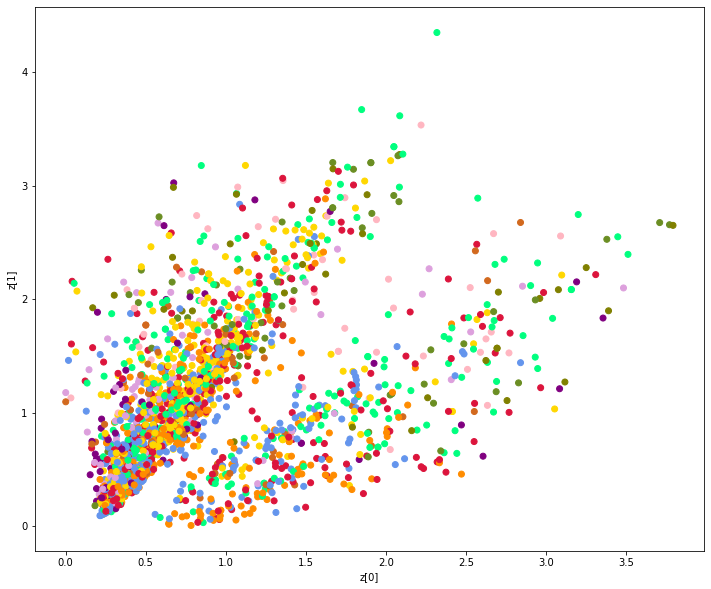

In [34]:
conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted",
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

colour_dict = {
    "angry": "crimson",
    "happy": "springgreen",
    "sad": "cornflowerblue",
    "disgusted": "darkorange"  ,
    "afraid": "gold",
    "pleased": "olive",
    "bored": "lightseagreen",
    "tired": "plum",
    "relaxed": "chocolate",
    "excited": "olivedrab",
    "miserable": "purple",
    "nervous": "lightslategray",
    "satisfied": "lightpink",   
}

def plot_label_clusters(autoencoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    encoded = autoencoder.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    
    actual_labels = []
    for i in range(len(labels)):
        point_coords = (labels.iloc[i][0], labels.iloc[i][1], labels.iloc[i][2])

        actual_labels.append(colour_dict[conv_dict[point_coords]])

    
    plt.scatter(encoded[:, 0], encoded[:, 1], c=actual_labels)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(autoencoder, test_dataset, test_emotions_OG)


## Test

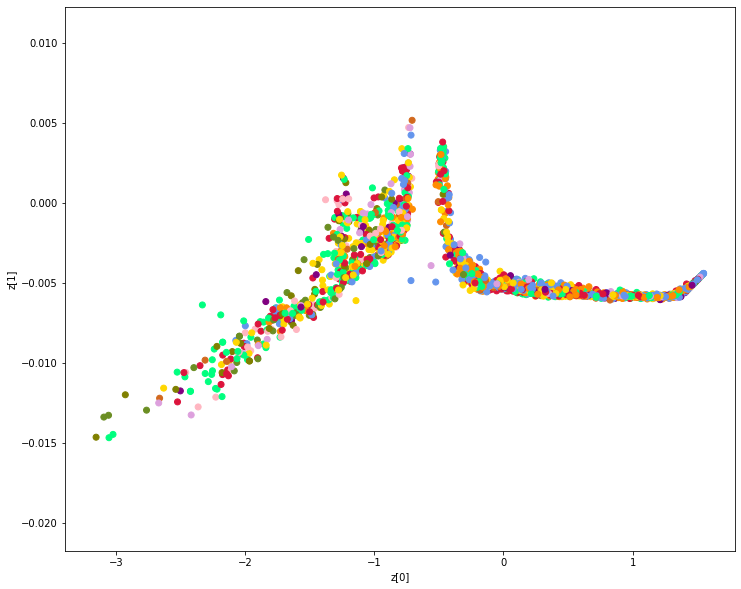

In [154]:
conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted",
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

colour_dict = {
    "angry": "crimson",
    "happy": "springgreen",
    "sad": "cornflowerblue",
    "disgusted": "darkorange"  ,
    "afraid": "gold",
    "pleased": "olive",
    "bored": "lightseagreen",
    "tired": "plum",
    "relaxed": "chocolate",
    "excited": "olivedrab",
    "miserable": "purple",
    "nervous": "lightslategray",
    "satisfied": "lightpink",   
}

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    
    actual_labels = []
    for i in range(len(labels)):
        point_coords = (labels.iloc[i][0], labels.iloc[i][1], labels.iloc[i][2])

        actual_labels.append(colour_dict[conv_dict[point_coords]])

    
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=actual_labels)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, test_dataset, test_emotions_OG)
